<Response [200]>
Stations available throug the API
{'dcmiPoint': 'name=Värriö; east=29.610137; north=67.755044; elevation=395;', 'id': 1, 'name': 'Värriö'}
{'dcmiPoint': 'name=Hyytiälä; east=24.294795; north=61.847463; elevation=179;', 'id': 2, 'name': 'Hyytiälä'}
{'dcmiPoint': 'name=Kumpula; east=24.961227; north=60.202887; elevation=30;', 'id': 3, 'name': 'Kumpula'}
{'dcmiPoint': 'name=Puijo; east=27.655278; north=62.909444; elevation=306;', 'id': 4, 'name': 'Puijo'}
{'dcmiPoint': 'name=Erottaja; east=24.9454; north=60.1652; elevation=23;', 'id': 5, 'name': 'Erottaja'}
{'dcmiPoint': 'name=Torni; east=24.9387; north=60.1678; elevation=15;', 'id': 6, 'name': 'Torni'}
{'dcmiPoint': 'name=Siikaneva 1; east=24.192794; north=61.832702; elevation=162;', 'id': 7, 'name': 'Siikaneva 1'}
{'dcmiPoint': 'name=Siikaneva 2; east=24.169752; north=61.837286; elevation=162;', 'id': 8, 'name': 'Siikaneva 2'}
{'dcmiPoint': 'name=Kuivajärvi; east=24.282; north=61.846; elevation=141;', 'id': 9, 'name': '

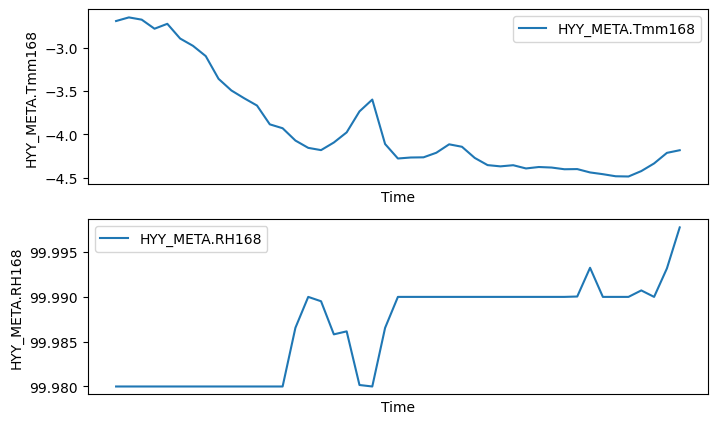

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime
import urllib.parse

def get_smear_data(days_to_fetch = 2, variables_to_fetch = ['HYY_META.Tmm168', 'HYY_META.RH168']):
    '''This function will fetch the observational data from Hyytiälä weather station.'''

    # Check the list of stations
    url = "https://smear-backend.2.rahtiapp.fi/search/station"
    response = requests.get(url)
    print(response)

    if response.status_code == 200:
        print(f"Stations available throug the API")
        data = response.json()
        for i in data:
            print(i)

    # Try to fetch the temperature data from 16.8 meters above ground level for the past two days
    datetime_end = datetime.datetime.now()
    num_days_to_fetch = datetime.timedelta(days = days_to_fetch)

    datetime_start = (datetime_end - num_days_to_fetch).isoformat()
    datetime_end = datetime_end.isoformat()

    print(f"\nFetching data from {datetime_start} to {datetime_end}.")

    dt_start = urllib.parse.quote_plus(datetime_start)
    dt_end = urllib.parse.quote_plus(datetime_end)

    # Formulate the url string
    fetch_request = "https://smear-backend.2.rahtiapp.fi/search/timeseries?aggregation=ARITHMETIC"

    # Add starting datetime
    fetch_request += "&from=" + dt_start

    # Add length of interval between data points (in minutes, 1-60)
    fetch_request += "&interval=60"
    # Add quality (ANY or CHECKED)
    fetch_request += "&quality=ANY"

    # Add request variables
    for var in variables_to_fetch:
        fetch_request += "&tablevariable=" + var

    # Finally, add the ending datetime
    fetch_request += "&to=" + dt_end

    print(f"Using the following URL:\n{fetch_request}")

    #fetch_request = "https://smear-backend.2.rahtiapp.fi/search/timeseries?aggregation=ARITHMETIC&from=2025-02-08T00%3A00%3A00.000&interval=60&quality=ANY&tablevariable=HYY_META.Tmm168&to=2025-02-09T00%3A00%3A00.000"

    response = requests.get(fetch_request)

    if response.status_code == 200:
        # Fetch OK, let's plot
        data = response.json()

        # A dictionary is returned, data will contain the measurements with time stamps
        df = pd.DataFrame.from_dict(data['data'])
        #print(df.columns)

        #df['hour'] = [datetime.datetime.fromisoformat(x).hour for x in df['samptime']]
        fig, axs = plt.subplots(len(variables_to_fetch),1, figsize=(8,5))
        for i in range(len(variables_to_fetch)):
            axs[i].plot(df['samptime'], df[variables_to_fetch[i]], label= variables_to_fetch[i])
            axs[i].set_xlabel('Time')
            axs[i].set_ylabel(variables_to_fetch[i])
            axs[i].set_xticks([])
            axs[i].legend()

get_smear_data()